<a href="https://colab.research.google.com/github/L22AR5N/LEEARON/blob/main/jang_LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time

import tensorflow as tf
import tensorflow.keras.callbacks as callbacks
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='HCR Dotum')
# import warnings
# warnings.filterwarnings("ignore")
# tf.set_random_seed(777)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from datetime import datetime
import joblib

In [81]:
###################################
# System Config
###################################

start_time = pd.to_datetime('2020-08-01 00:00:00')
end_time = pd.to_datetime('2020-08-14 23:00:00')

daeam = ['set_date', '방류량합계', '시간강우', '비룡수위']


# default train size rate
trainSize_rate = 0.8  # 학습 및 예측 셋 구분
current_time = datetime.today().strftime("%Y%m%d_%H%M%S")

seqLength = 6  # window size
hiddenDim = 10  # hiddenUnit 수
outputDim = 1  # output
# lr = 0.0001  # 학습률
drop_rate = 0.3  # Layer를 통과하여 생성된 파라메터의 수를 조정해주는 비율
target = 24  # 예측할 시간(0: 1시간, 2: 3시간, 5: 6시간)  -> 6 - 1시간, 12 - 2시간, 18 -3시간, 24 -4시간 30 - 5시간

model_list = ["GBM","RF","LSTM"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF
performance_list = ["RMSE", "R2", "MSE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE


In [42]:
# callsback 설정
# Early Stopping, ModelCheckpoint 설정
# Early Stopping : 모델의 학습이 더이상 진전이 없으면 학습을 종료j
# ModelCheckpoint : 모델 학습 중 학습이 잘되어진 모델을 계속해서 저장
cbs = [callbacks.EarlyStopping(monitor='val_loss',
                               patience=10,
                               mode='min'),
       # callbacks.ModelCheckpoint(filepath='bestModel.h5',
       #                           monitor='val_loss',
       #                           mode='min',
       #                           save_best_only=True)
       ]

In [4]:
# def1 : data extraction

# Date 형 변환
def set_date(rawframe):
    rawframe['set_date'] = pd.to_datetime(rawframe[rawframe.columns[0]], format='%Y%m%d %H:%M', errors='coerce')
    rawframe = rawframe.drop(rawframe.columns[0], axis=1)
    return rawframe


In [5]:
# DataFrame merge
def set_merge(tb1, tb2):
    raw_return = pd.merge(tb1, tb2, how='outer', on='set_date')
    return raw_return

In [6]:
# 데이터 결측 범위 지정 결측값 도출
def set_outlier(df1):
    columns = list(range(1, df1.shape[1]))
    for i in columns:
        df1[df1.columns[i]].mask(
            (df1[df1.columns[i]] >= 16000) | (df1[df1.columns[i]] < -30), inplace=True)
    return df1

In [7]:
# 입출력 자료 통합차트
def total_chart(df1, list1):
    columns = list(range(1, len(list1)))
    i = 1
    values = df1.values
    plt.figure(figsize=(9, 40))
    for variable in columns:
        plt.subplot(len(columns), 1, i)
        plt.plot(values[:, variable])
        plt.title(df1.columns[variable], y=0.5, loc='right')
        i += 1
    plt.show()

In [8]:
#  기본 차트 : 이미지 저장용
def basic_chart(obsY, preY, str_part):
    if str_part == 'line':
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(preY)), preY, '-x', label="predict Y")
        ax.plot(range(len(obsY)), obsY, '-', label="Original Y")
    plt.legend(loc='upper right')

In [9]:
# RandomForest Regression Algorithm
def AL_RandomForest(trainX, trainY, testX, testY):
    rf_clf = RandomForestRegressor(n_estimators=100, random_state=15)
    rf_clf.fit(trainX, np.ravel(trainY, order="C"))
    # joblib.dump(rf_clf, )

    # relation_square = rf_clf.score(trainX, trainY)
    # print('RandomForest 학습 결정계수 : ', relation_square)

    y_pred1 = rf_clf.predict(trainX)
    y_pred2 = rf_clf.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return rf_clf, y_pred2

In [10]:
# GBR(GradientBoostingRegression) Algorithm
def AL_GradientBoosting(trainX, trainY, testX, testY):

    trainX.columns = pd.RangeIndex(trainX.shape[1])
    testX.columns = pd.RangeIndex(testX.shape[1])

    gbr_model = GradientBoostingRegressor(n_estimators=100, max_depth=3)
    gbr_model.fit(trainX, np.ravel(trainY, order="C"))

    y_pred = gbr_model.predict(trainX)
    y_pred2 = gbr_model.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return gbr_model, y_pred2

In [11]:
# XGBoosting Algorithm
def AL_XGBoosting(trainX, trainY, testX, testY):

    trainX.columns = pd.RangeIndex(trainX.shape[1])
    testX.columns = pd.RangeIndex(testX.shape[1])

    xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, max_depth=3)
    xgb_model.fit(trainX, np.ravel(trainY, order="C"))

    y_pred = xgb_model.predict(trainX)
    y_pred2 = xgb_model.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return y_pred2

In [46]:
# LSTM Algorithm
def AL_LSTM(trainX, trainY, testX, testY):
    # 모델 트레이닝
    model = keras.Sequential()
    # , activation='tanh'
    model.add(tf.keras.layers.Bidirectional(layers.LSTM(hiddenDim, return_sequences=True),
                                            input_shape=[seqLength, dataDim]))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Bidirectional(layers.LSTM(10)))
    model.add(layers.Dense(1))

    # optimizer 설정
    # opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)  # replace "lr" with "learning_rate"
    # opt = optimizers.Adam(lr=lr)
    opt = keras.optimizers.Adam(learning_rate=0.0001)

    # 모델 학습과정 설정
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    # 모델 학습습
    his = model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=0,
                    validation_split=0.2,
                    callbacks=cbs)

    # 모델 테스트
    y_pred = model.predict(trainX)
    y_pred2 = model.predict(testX)

    return model, y_pred2

In [13]:
# 알고리즘 실행 성능지표 함수
def Performance_index(obs, pre, mod_str):
    if mod_str == 'R2':
        pf_index = r2_score(obs, pre)
    elif mod_str == 'RMSE':
        s1 =  mean_squared_error(obs, pre)
        pf_index = np.sqrt(s1)
    elif mod_str == 'MSE':
        pf_index = mean_squared_error(obs, pre)
    elif mod_str == 'MAE':
        pf_index = mean_absolute_error(obs, pre)

    return pf_index

In [14]:
# 정규화 함수
def MinMaxScaler(data):
    denom = np.max(data, 0) - np.min(data, 0)
    nume = data - np.min(data, 0)
    return nume / denom

In [15]:
# 정규화 되돌리기 함수
def back_MinMax(data, value):
    diff = np.max(data, 0) - np.min(data, 0)
    back = value * diff + np.min(data, 0)
    return back

In [16]:
# 각 지점의 알맞는 학습 배치 데이터 생성 함수
def buildDataSet(timeSeries, seqLength, target):
    xdata = []
    ydata = []
    for i in range(0, len(timeSeries) - seqLength - target):
        tx = timeSeries[i:i + seqLength]
        # print(tx)
        ty = timeSeries.iloc[i + seqLength + target, -1]
        # print(ty)
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [17]:
# 각 지점의 알맞는 학습 배치 데이터 생성 함수
def buildDataSet2(timeSeries, seqLength, target):
    xdata = pd.DataFrame()
    # ydata = pd.DataFrame()
    for s in range(0, seqLength):
        tx = timeSeries.iloc[(seqLength - s):(len(timeSeries) - s - target), :].reset_index()
        xdata = pd.concat([xdata, tx], axis=1, ignore_index=False)

    xdata = xdata.drop(['index'], axis='columns')
    ydata = timeSeries.iloc[seqLength + target:, -1]
    return xdata, ydata

In [18]:
def makeDir(model):
    path_result_data = "./result_data/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_data):
        os.makedirs(path_result_data)
    path_result_graph = "./result_graph/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_graph):
        os.makedirs(path_result_graph)
    path_result_model = "./result_model/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_model):
        os.makedirs(path_result_model)

    path_list = pd.DataFrame([(path_result_data, path_result_graph, path_result_model)], columns=['data','graph','model'])
    return path_list

In [19]:
###################################
print("Modulation 1 : 데이터 전처리")
###################################
# 추후 3개의 csv로 적용
# raw_flood1 = pd.read_csv('/content/drive/MyDrive/jang/raindragon.csv', sep=',', encoding='ISO-8859-1')
raw_flood1 = pd.read_csv('/content/drive/MyDrive/jang/raindragon_ch_2.csv', sep=',', encoding='CP949')
raw_flood2 = set_date(raw_flood1)

# raw_flood2 = pd.read_csv('/content/drive/MyDrive/jang/taehwa.csv', sep=',', encoding='CP949')
# raw_flood2 = set_date(raw_flood2)

# raw_rainfall = pd.read_csv('/content/drive/MyDrive/jang/rainfall.csv', sep=',', encoding='CP949')
# raw_rainfall = set_date(raw_rainfall)

# raw_tidal = pd.read_csv('/content/drive/MyDrive/jang/tidal.csv', sep=',', encoding='CP949')
# raw_tidal = set_date(raw_tidal)

raw_timeset = pd.DataFrame(pd.date_range(start_time, end_time, freq='H'))
raw_timeset.columns = ['set_date']

Modulation 1 : 데이터 전처리


In [20]:
print(raw_flood1.shape)
print(raw_flood1.head)

(2011, 4)
<bound method NDFrame.head of                 set_date    방류량합계  시간강우  비룡수위
0    2020-08-01 00:00:00   55.400   0.0  0.43
1    2020-08-01 00:10:00   55.400   0.0  0.43
2    2020-08-01 00:20:00   55.256   0.2  0.43
3    2020-08-01 00:30:00   55.184   0.2  0.43
4    2020-08-01 00:40:00   55.016   0.0  0.43
...                  ...      ...   ...   ...
2006 2020-08-14 02:20:00  435.231   0.0  1.73
2007 2020-08-14 02:30:00  437.645   0.0  1.72
2008 2020-08-14 02:40:00  438.064   0.0  1.72
2009 2020-08-14 02:50:00  440.882   0.0  1.70
2010 2020-08-14 03:00:00  443.175   0.0  1.69

[2011 rows x 4 columns]>


In [21]:
# raw_total = set_merge(raw_timeset, raw_flood1)
# raw_total = set_merge(raw_total, raw_flood2)
# raw_total = set_merge(raw_total, raw_rainfall)
# raw_total = set_merge(raw_total, raw_tidal)

In [21]:
temp_daeam = pd.DataFrame(raw_flood1, columns=daeam)
# temp_sayeon = pd.DataFrame(raw_total, columns=sayeon)
# temp_guyoung = pd.DataFrame(raw_total, columns=guyoung)
# temp_samho = pd.DataFrame(raw_total, columns=samho)
# temp_taewha = pd.DataFrame(raw_total, columns=taewha)

In [22]:
# temp_daeam = set_outlier(temp_daeam)
temp_daeam1 = set_outlier(temp_daeam)
# temp_sayeon = set_outlier(temp_sayeon)
# temp_guyoung = set_outlier(temp_guyoung)
# temp_samho = set_outlier(temp_samho)
# temp_taewha = set_outlier(temp_taewha)

In [56]:
# Error Data Control : Delete & temp set make 결측값 제거
# temp_daeam = temp_daeam.dropna(how='any')
# temp_sayeon = temp_sayeon.dropna(how='any')
# temp_guyoung = temp_guyoung.dropna(how='any')
# temp_samho = temp_samho.dropna(how='any')
# temp_taewha = temp_taewha.dropna(how='any')

In [24]:
## 데이터 shape 확인
print(temp_daeam1.shape)
# print(temp_sayeon.shape)
# print(temp_guyoung.shape)
# print(temp_samho.shape)
# print(temp_taewha.shape)

print(temp_daeam1.head())
# print(temp_sayeon.head())
# print(temp_guyoung.head())
# print(temp_samho.head())
# print(temp_taewha.head())

(2011, 4)
             set_date   방류량합계  시간강우  비룡수위
0 2020-08-01 00:00:00  55.400   0.0  0.43
1 2020-08-01 00:10:00  55.400   0.0  0.43
2 2020-08-01 00:20:00  55.256   0.2  0.43
3 2020-08-01 00:30:00  55.184   0.2  0.43
4 2020-08-01 00:40:00  55.016   0.0  0.43


In [25]:
# temp_list = [temp_daeam, temp_sayeon, temp_guyoung, temp_samho, temp_taewha]
# temp_list_name = ["daeam", "sayeon", "guyoung", "samho", "taewha"]

temp_list = [temp_daeam1]
temp_list_name = ["daeam"]

# temp_list = [raw_flood1]
# temp_list_name = ["daeam"]

In [82]:
def run():

  ###################################
  # 각 지점마다 모델 생성 및 학습
  ###################################
  target_list = [0,24]
  for t in target_list:
      for md in model_list:
          print("=" * 30)
          print("model : ", md)
          print("=" * 30)
          count = 0

          start = time.time()  # 시작 시간 저장
          for df in temp_list:
              """
              Modulation 2 : 학습데이터 정제
              """
              # print("Modulation 2 : 학습데이터 정제")
              # 날짜 데이터를 제외한 나머지 값
              # xy = df.drop(['set_date'], axis='columns')
              xy = df.drop(['set_date'], axis='columns')

              dataDim = len(xy.columns)  # 매개변수의 개수

              # train셋과 test셋을 분류(0.8 비율)
              trainSize = int(len(xy) * trainSize_rate)
              trainSet = xy[0:trainSize]
              testSet = xy[trainSize - seqLength:]

              """
              Modulation 3 : 모델 학습
              """
              # print("Modulation 3 : 모델 학습")
              if md == "LSTM":
                  # MinMaxScaler(trainSet)
                  # MinMaxScaler(testSet)

                  # 각 지점의 알맞는 학습 배치 데이터 생성
                  trainX, trainY = buildDataSet(trainSet, seqLength, t)
                  testX, testY = buildDataSet(testSet, seqLength, t)
                  model, predict = AL_LSTM(trainX, trainY, testX, testY)

                  # yhat = back_MinMax(xy[xy.columns[-1]], predict)
                  # actual = back_MinMax(xy[xy.columns[-1]], testY)
                  yhat = predict
                  actual = testY

              else:
                  if md == "GBM":
                      # 각 지점의 알맞는 학습 배치 데이터 생성
                      trainX, trainY = buildDataSet2(trainSet, seqLength, t)
                      testX, testY = buildDataSet2(testSet, seqLength, t)
                      model, predict = AL_GradientBoosting(trainX, trainY, testX, testY)
                  elif md == "RF":
                      # 각 지점의 알맞는 학습 배치 데이터 생성
                      trainX, trainY = buildDataSet2(trainSet, seqLength, t)
                      testX, testY = buildDataSet2(testSet, seqLength, t)
                      model, predict = AL_RandomForest(trainX, trainY, testX, testY)

                  yhat = predict
                  actual = testY

              # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
              for pi in performance_list:
                  rmse = Performance_index(actual, yhat, pi)
                  print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)

              # print(temp_list_name[count])
              # actual = actual.to_numpy()
              # tmp = actual - yhat
              # tmp = abs(tmp)
              # print(tmp)
              # exit(1)
              # print(type(actual))
              # print(type(yhat))
              # print("평균 :", np.mean(tmp))
              # print("분산 :", np.var(tmp))
              # print("표준편차 :", np.std(tmp))
              # exit(1)


              """
              Modulation 4 : 결과 데이터 저장
              """
              # print("Modulation 4 : 결과 데이터 저장")
              #
              dir_list = makeDir(md)
              # # # 복원된 데이터 저장
              pd_actual_save = pd.DataFrame(actual).reset_index()
              pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual.csv", mode='w')

              pd_predict_save = pd.DataFrame(yhat).reset_index()
              pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count] + ".csv", mode='w')
              #
              # 그래프 저장
              basic_chart(actual, yhat, 'line')
              plt.title(md + " : " + temp_list_name[count])
              plt.savefig(dir_list['graph'][0] + temp_list_name[count] + '.png')

              count += 1
          print(md, ", time :", time.time() - start)

  plt.show()


model :  GBM
daeam GBM 예측 RMSE :  0.036353417257521094
daeam GBM 예측 R2 :  0.9987550279568981
daeam GBM 예측 MSE :  0.0013215709462994323
GBM , time : 1.3636524677276611
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 2.094633102416992
model :  LSTM
daeam LSTM 예측 RMSE :  0.9620010777487508
daeam LSTM 예측 R2 :  0.1281932368112101
daeam LSTM 예측 MSE :  0.9254460735897581
LSTM , time : 61.427751541137695
model :  GBM
daeam GBM 예측 RMSE :  0.34010344836081113
daeam GBM 예측 R2 :  0.8848969379101526
daeam GBM 예측 MSE :  0.11567035558691491
GBM , time : 0.7689106464385986
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 2.1180200576782227
model :  LSTM
daeam LSTM 예측 RMSE :  0.39469346049582904
daeam LSTM 예측 R2 :  0.8449810937702729
daeam LSTM 예측 MSE :  0.15578292775817257
LSTM , time : 91.55062818527222


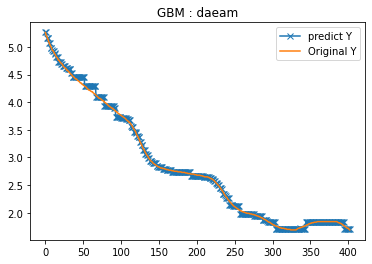

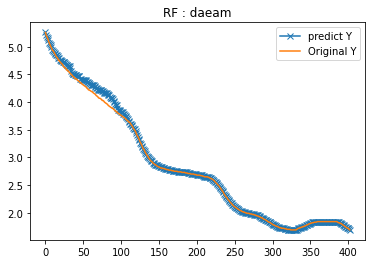

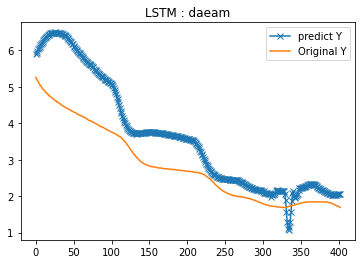

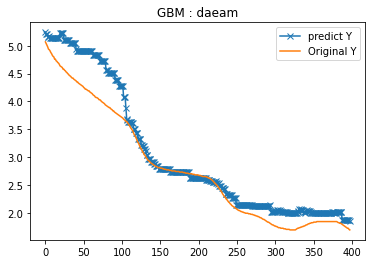

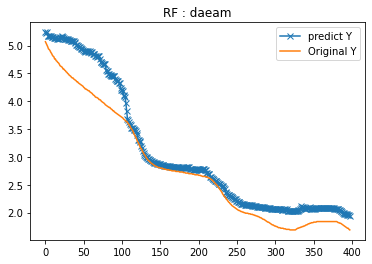

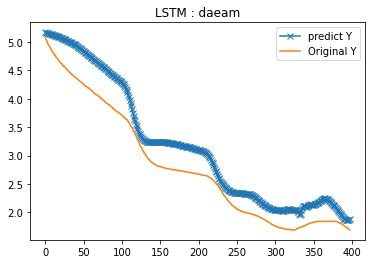

In [56]:
#3시간 예측 결과 x
run()

model :  GBM
daeam GBM 예측 RMSE :  0.03642421464656385
daeam GBM 예측 R2 :  0.9987501741300652
daeam GBM 예측 MSE :  0.0013267234126189565
GBM , time : 0.7936484813690186
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 1.3404812812805176
model :  LSTM
daeam LSTM 예측 RMSE :  0.47963673123909256
daeam LSTM 예측 R2 :  0.7832824981882525
daeam LSTM 예측 MSE :  0.2300513939537215
LSTM , time : 91.74833869934082
model :  GBM
daeam GBM 예측 RMSE :  0.3403097361897712
daeam GBM 예측 R2 :  0.8847572653375648
daeam GBM 예측 MSE :  0.11581071654555167
GBM , time : 0.7786762714385986
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 1.4060676097869873
model :  LSTM
daeam LSTM 예측 RMSE :  0.2378854744066601
daeam LSTM 예측 R2 :  0.9436880385095507
daeam LSTM 예측 MSE :  0.056589498933681745
LSTM , time : 91.65612983703613


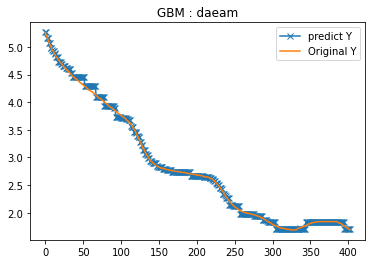

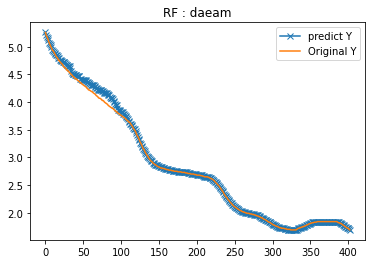

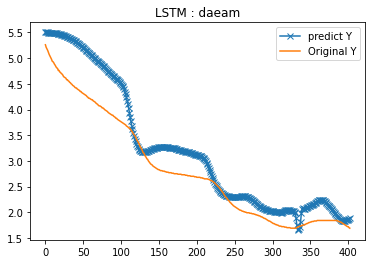

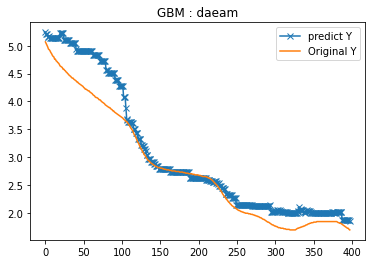

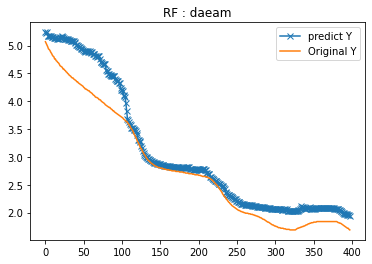

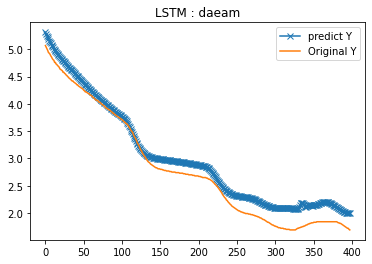

In [52]:
# 5시간 예측 결과 x
run()

model :  GBM
daeam GBM 예측 RMSE :  0.036303763233642726
daeam GBM 예측 R2 :  0.9987584265729648
daeam GBM 예측 MSE :  0.0013179632249243891
GBM , time : 0.7850193977355957
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 1.3761253356933594
model :  LSTM
daeam LSTM 예측 RMSE :  0.6090260512751196
daeam LSTM 예측 R2 :  0.650585553516712
daeam LSTM 예측 MSE :  0.3709127311317645
LSTM , time : 68.26219630241394
model :  GBM
daeam GBM 예측 RMSE :  0.33927784596004495
daeam GBM 예측 R2 :  0.8854550858665142
daeam GBM 예측 MSE :  0.115109456759288
GBM , time : 0.8175370693206787
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 1.393723726272583
model :  LSTM
daeam LSTM 예측 RMSE :  0.5736131460620221
daeam LSTM 예측 R2 :  0.6725816628540242
daeam LSTM 예측 MSE :  0.3290320413351706
LSTM , time : 90.96177911758423


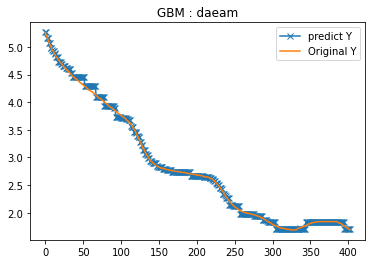

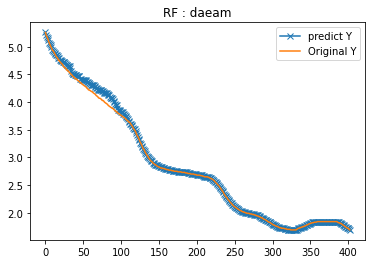

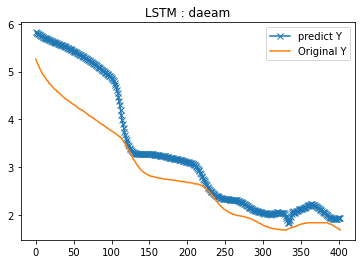

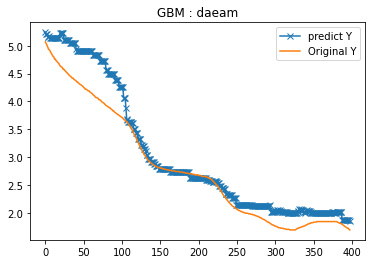

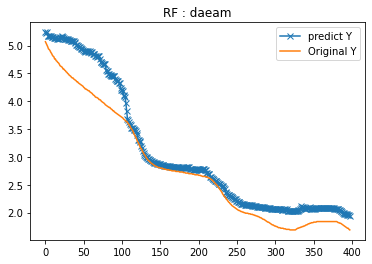

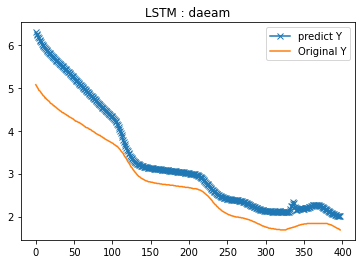

In [54]:
# 6시간 예측 결과 x
run()

model :  GBM
daeam GBM 예측 RMSE :  0.03631332194400722
daeam GBM 예측 R2 :  0.9987577726791467
daeam GBM 예측 MSE :  0.0013186573506091164
GBM , time : 1.8251075744628906
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 2.2147202491760254
model :  LSTM
daeam LSTM 예측 RMSE :  0.6573425193084939
daeam LSTM 예측 R2 :  0.592945494126927
daeam LSTM 예측 MSE :  0.4320991876908376
LSTM , time : 54.587719202041626
model :  GBM
daeam GBM 예측 RMSE :  0.34035509073494075
daeam GBM 예측 R2 :  0.884726545498802
daeam GBM 예측 MSE :  0.11584158778918975
GBM , time : 0.7655832767486572
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 1.4015767574310303
model :  LSTM
daeam LSTM 예측 RMSE :  0.2865033889733832
daeam LSTM 예측 R2 :  0.918318381679198
daeam LSTM 예측 MSE :  0.08208419189323371
LSTM , time : 56.35609841346741


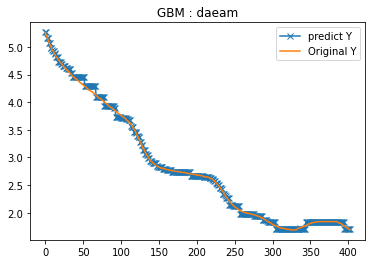

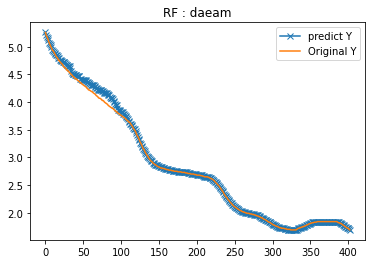

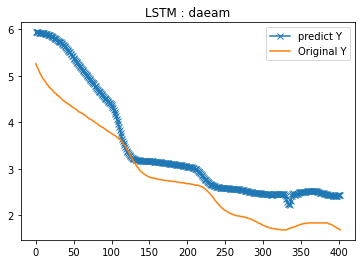

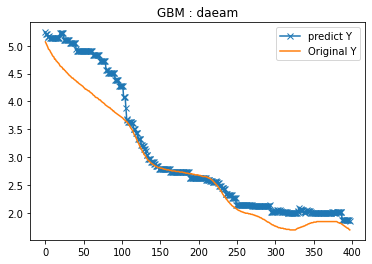

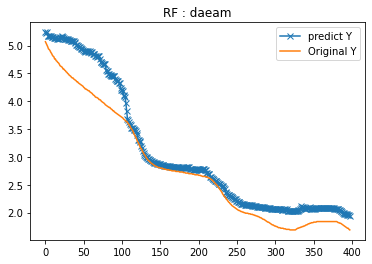

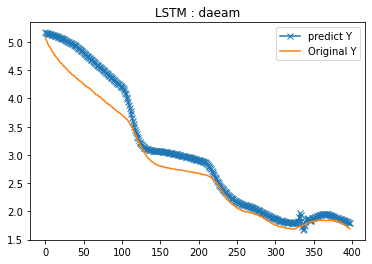

In [58]:
# 12 - 2시간 예측 결과
run()

model :  GBM
daeam GBM 예측 RMSE :  0.03634575470774678
daeam GBM 예측 R2 :  0.9987555527303904
daeam GBM 예측 MSE :  0.0013210138852756974
GBM , time : 1.0859777927398682
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 2.1193485260009766
model :  LSTM
daeam LSTM 예측 RMSE :  0.45399844576113524
daeam LSTM 예측 R2 :  0.8058319143651623
daeam LSTM 예측 MSE :  0.20611458875352645
LSTM , time : 50.98364806175232
model :  GBM
daeam GBM 예측 RMSE :  0.3403821815276982
daeam GBM 예측 R2 :  0.8847081942319399
daeam GBM 예측 MSE :  0.1158600295015549
GBM , time : 0.7707676887512207
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 1.4117984771728516
model :  LSTM
daeam LSTM 예측 RMSE :  0.14350444558950856
daeam LSTM 예측 R2 :  0.9795074729497967
daeam LSTM 예측 MSE :  0.020593525903952227
LSTM , time : 63.37890315055847


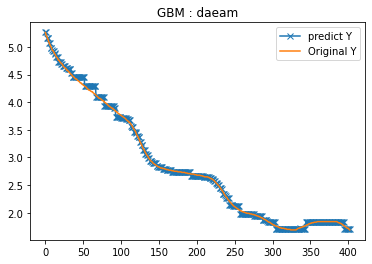

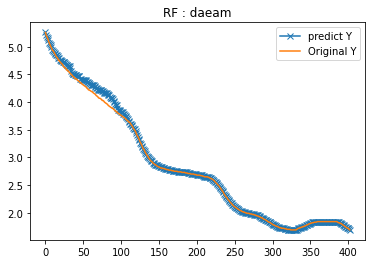

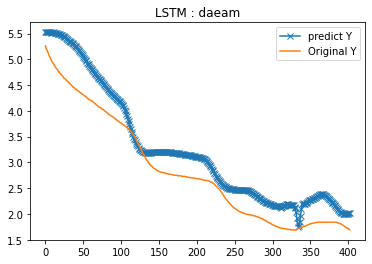

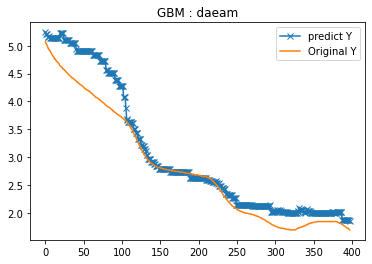

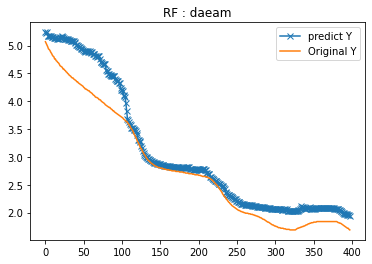

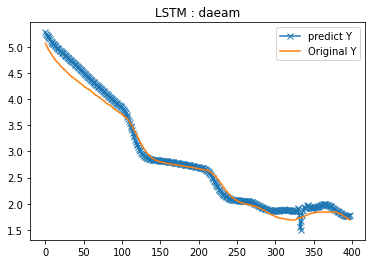

In [60]:
# 18 - 3시간 예측 결과
run()

model :  GBM
daeam GBM 예측 RMSE :  0.036399208389938785
daeam GBM 예측 R2 :  0.9987518896228245
daeam GBM 예측 MSE :  0.0013249023714141902
GBM , time : 0.7896947860717773
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 1.3415398597717285
model :  LSTM
daeam LSTM 예측 RMSE :  0.43858784668622447
daeam LSTM 예측 R2 :  0.8187899405014782
daeam LSTM 예측 MSE :  0.19235929926085912
LSTM , time : 91.02473187446594
model :  GBM
daeam GBM 예측 RMSE :  0.339274982392405
daeam GBM 예측 R2 :  0.8854570194187877
daeam GBM 예측 MSE :  0.11510751367736673
GBM , time : 0.7716960906982422
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 1.3924822807312012
model :  LSTM
daeam LSTM 예측 RMSE :  0.2971374704354212
daeam LSTM 예측 R2 :  0.9121423363075194
daeam LSTM 예측 MSE :  0.08829067633676083
LSTM , time : 62.41790723800659


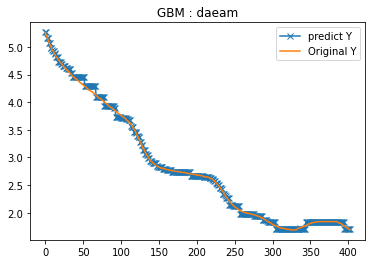

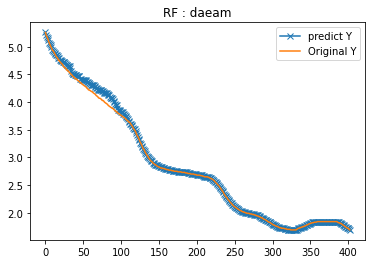

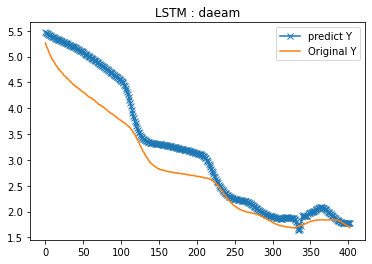

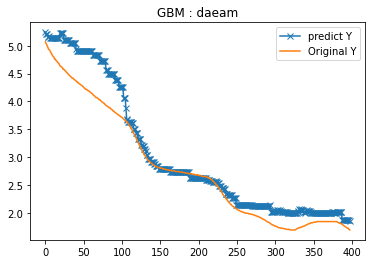

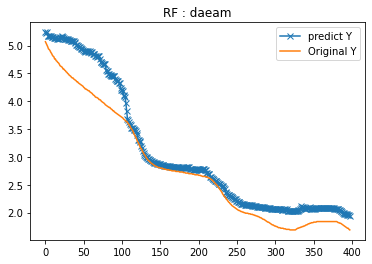

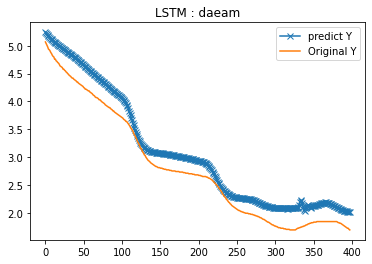

In [62]:
# 24 - 4시간 예측 결과
run()

model :  GBM
daeam GBM 예측 RMSE :  0.03643274757740318
daeam GBM 예측 R2 :  0.9987495884797226
daeam GBM 예측 MSE :  0.0013273450960387774
GBM , time : 1.1294541358947754
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 2.126448154449463
model :  LSTM
daeam LSTM 예측 RMSE :  0.23925654321067857
daeam LSTM 예측 R2 :  0.946074179208836
daeam LSTM 예측 MSE :  0.05724369346912331
LSTM , time : 65.05089831352234
model :  GBM
daeam GBM 예측 RMSE :  0.34029234634327543
daeam GBM 예측 R2 :  0.8847690428569761
daeam GBM 예측 MSE :  0.11579888097981172
GBM , time : 0.7763681411743164
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 1.420661449432373
model :  LSTM
daeam LSTM 예측 RMSE :  0.2402587521445295
daeam LSTM 예측 R2 :  0.942558834820595
daeam LSTM 예측 MSE :  0.057724267982046454
LSTM , time : 91.05893468856812


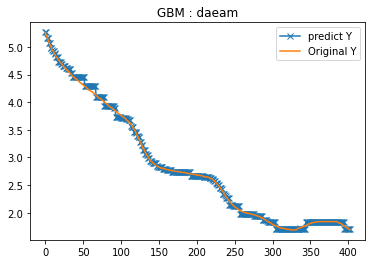

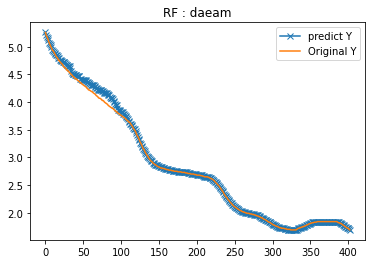

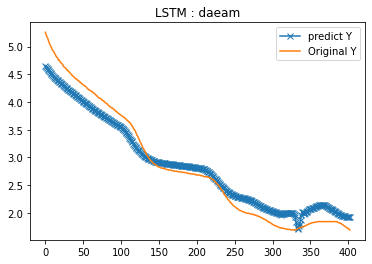

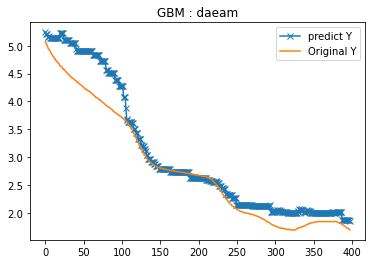

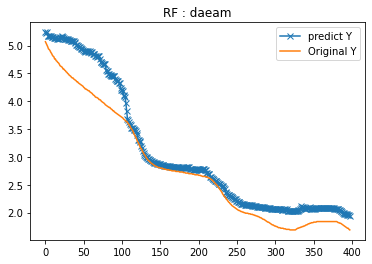

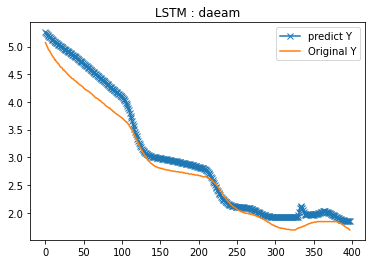

In [64]:
# 30 - 5시간 예측 결과
run()

model :  GBM
daeam GBM 예측 RMSE :  0.03635530237751331
daeam GBM 예측 R2 :  0.9987548988365724
daeam GBM 예측 MSE :  0.0013217080109604253
GBM , time : 1.1115868091583252
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 2.1099627017974854
model :  LSTM
daeam LSTM 예측 RMSE :  0.1675488752753169
daeam LSTM 예측 R2 :  0.9735544776057397
daeam LSTM 예측 MSE :  0.028072625606023697
LSTM , time : 92.97053408622742
model :  GBM
daeam GBM 예측 RMSE :  0.34056527017023436
daeam GBM 예측 R2 :  0.884584131937073
daeam GBM 예측 MSE :  0.11598470324612473
GBM , time : 0.7706241607666016
model :  RF
daeam RF 예측 RMSE :  0.34948189822354064
daeam RF 예측 R2 :  0.8784614142399408
daeam RF 예측 MSE :  0.12213759718592922
RF , time : 1.4137794971466064
model :  LSTM
daeam LSTM 예측 RMSE :  0.26123772387854555
daeam LSTM 예측 R2 :  0.9320895530134836
daeam LSTM 예측 MSE :  0.0682451483772432
LSTM , time : 92.27634310722351


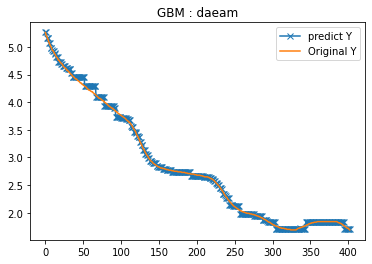

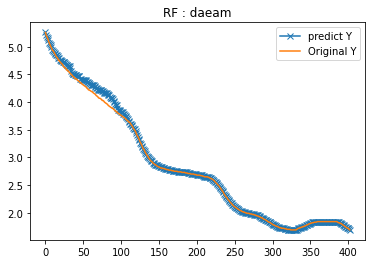

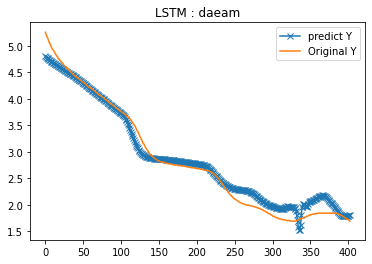

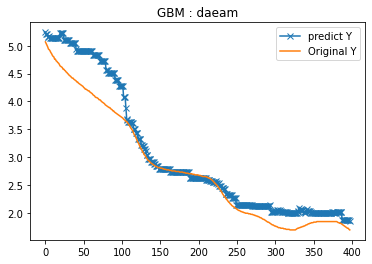

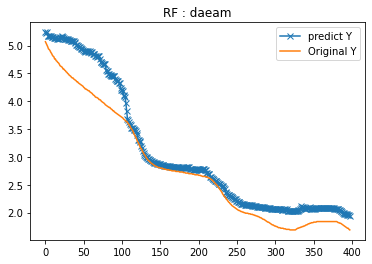

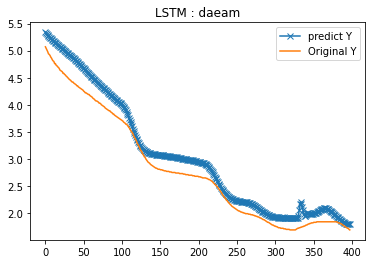

In [66]:
# 36 - 6시간 예측 결과
run()

model :  GBM
daeam GBM 예측 RMSE :  0.036311434644587644
daeam GBM 예측 R2 :  0.9987579017994723
daeam GBM 예측 MSE :  0.0013185202859481598
GBM , time : 0.798386812210083
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 1.343902587890625
model :  LSTM
daeam LSTM 예측 RMSE :  0.5319182910737049
daeam LSTM 예측 R2 :  0.7334621035101323
daeam LSTM 예측 MSE :  0.2829370683787707
LSTM , time : 91.59125566482544
model :  GBM
daeam GBM 예측 RMSE :  0.5144540913013582
daeam GBM 예측 R2 :  0.7174514379345738
daeam GBM 예측 MSE :  0.2646630120567062
GBM , time : 0.7767224311828613
model :  RF
daeam RF 예측 RMSE :  0.5988724384367515
daeam RF 예측 R2 :  0.6171148672837989
daeam RF 예측 MSE :  0.3586481975191807
RF , time : 1.4109437465667725
model :  LSTM
daeam LSTM 예측 RMSE :  0.1811050862433975
daeam LSTM 예측 R2 :  0.9649844344244886
daeam LSTM 예측 MSE :  0.03279905226322845
LSTM , time : 91.58719229698181


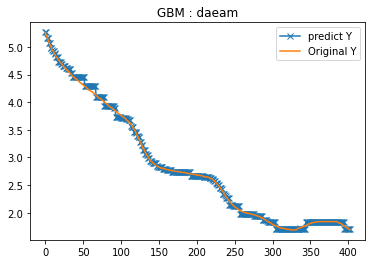

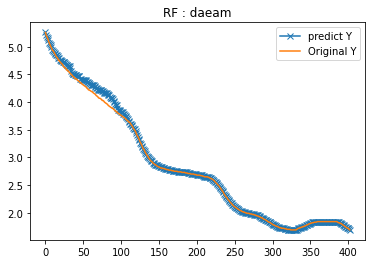

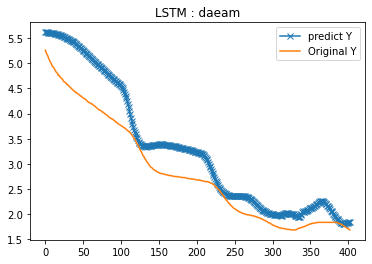

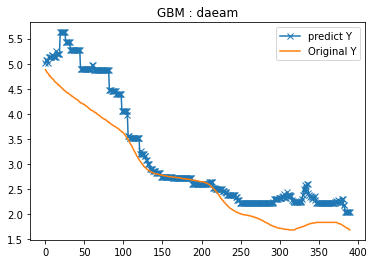

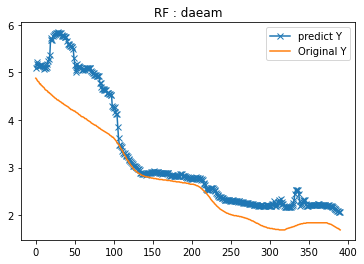

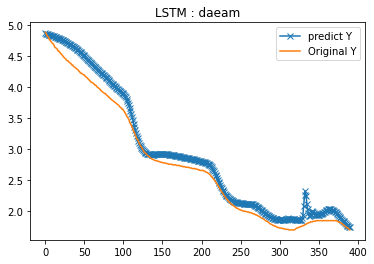

In [77]:
# 12 - 2시간 예측 결과 target[0,12]
run()


model :  GBM
daeam GBM 예측 RMSE :  0.03640874204224752
daeam GBM 예측 R2 :  0.9987512357290064
daeam GBM 예측 MSE :  0.001325596497098922
GBM , time : 0.7828390598297119
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 1.334932804107666
model :  LSTM
daeam LSTM 예측 RMSE :  0.19946618934256286
daeam LSTM 예측 R2 :  0.9625192995620974
daeam LSTM 예측 MSE :  0.03978676069084313
LSTM , time : 91.95764756202698
model :  GBM
daeam GBM 예측 RMSE :  0.6375462283100566
daeam GBM 예측 R2 :  0.5404614532241094
daeam GBM 예측 MSE :  0.4064651932323788
GBM , time : 0.7673795223236084
model :  RF
daeam RF 예측 RMSE :  0.9648104839407993
daeam RF 예측 R2 :  -0.0524042975269039
daeam RF 예측 MSE :  0.9308592699220793
RF , time : 1.428283929824829
model :  LSTM
daeam LSTM 예측 RMSE :  0.7722686831424477
daeam LSTM 예측 R2 :  0.3257275233353497
daeam LSTM 예측 MSE :  0.5963989189625702
LSTM , time : 90.96677446365356


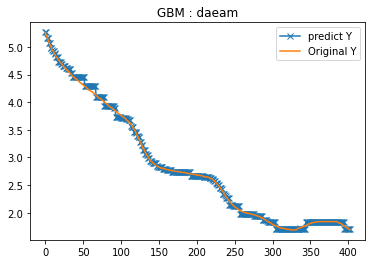

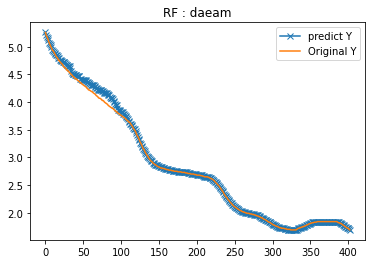

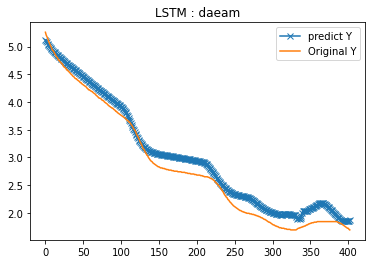

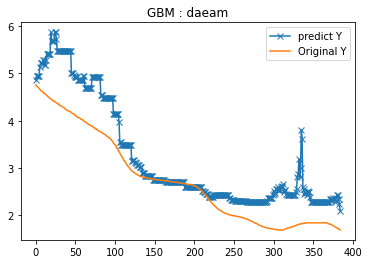

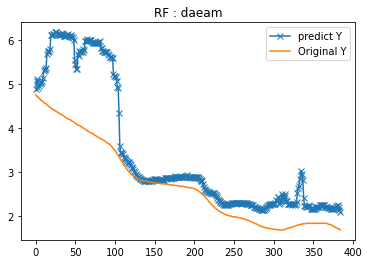

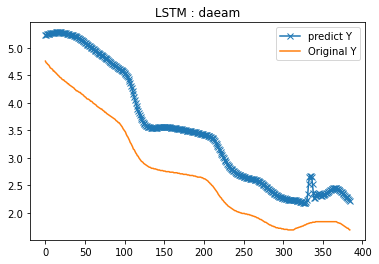

In [80]:
# 18 - 3시간 예측 결과 target[0,18]
run()


model :  GBM
daeam GBM 예측 RMSE :  0.03652581411176075
daeam GBM 예측 R2 :  0.9987431920310083
daeam GBM 예측 MSE :  0.0013341350965269008
GBM , time : 1.4023127555847168
model :  RF
daeam RF 예측 RMSE :  0.05578540858875425
daeam RF 예측 R2 :  0.9970683619264918
daeam RF 예측 MSE :  0.0031120118114142566
RF , time : 2.222914218902588
model :  LSTM
daeam LSTM 예측 RMSE :  0.42971601140396276
daeam LSTM 예측 R2 :  0.8260468936171717
daeam LSTM 예측 MSE :  0.18465585045693067
LSTM , time : 63.684086322784424
model :  GBM
daeam GBM 예측 RMSE :  0.7120157342539399
daeam GBM 예측 R2 :  0.39344862751629417
daeam GBM 예측 MSE :  0.5069664058251772
GBM , time : 0.7557437419891357
model :  RF
daeam RF 예측 RMSE :  1.2576213069581161
daeam RF 예측 R2 :  -0.8922921225067975
daeam RF 예측 MSE :  1.5816113517150403
RF , time : 1.4005775451660156
model :  LSTM
daeam LSTM 예측 RMSE :  1.186443708671045
daeam LSTM 예측 R2 :  -0.684157422040397
daeam LSTM 예측 MSE :  1.4076486738451037
LSTM , time : 91.68047189712524


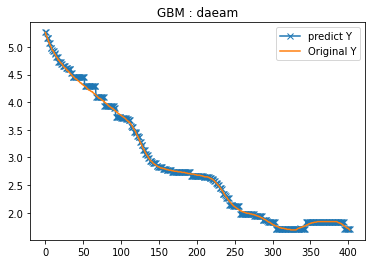

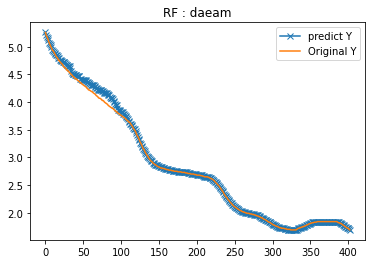

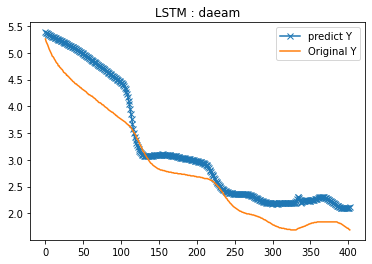

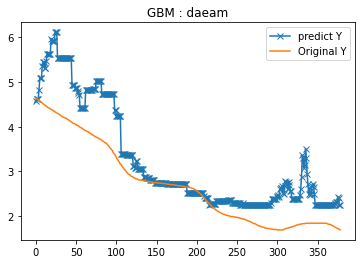

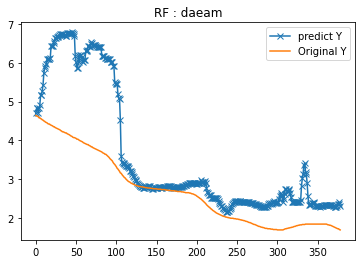

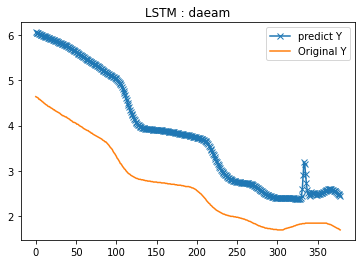

In [83]:
# 24 - 4시간 예측 결과 target[0,24]
run()
